In [40]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [41]:
BASE_DIR = '/Users/apple/Desktop/projects/face_gender_age/UTKFace/'

In [42]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [43]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/Users/apple/Desktop/projects/face_gender_age/...,9,1
1,/Users/apple/Desktop/projects/face_gender_age/...,36,0
2,/Users/apple/Desktop/projects/face_gender_age/...,86,1
3,/Users/apple/Desktop/projects/face_gender_age/...,26,1
4,/Users/apple/Desktop/projects/face_gender_age/...,1,1


In [44]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

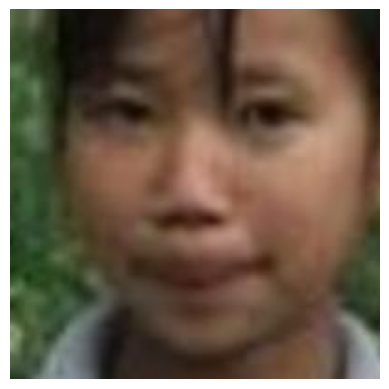

In [45]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

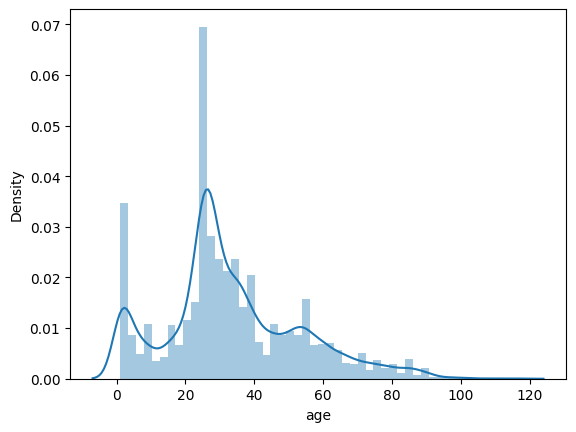

In [46]:
sns.distplot(df['age'])

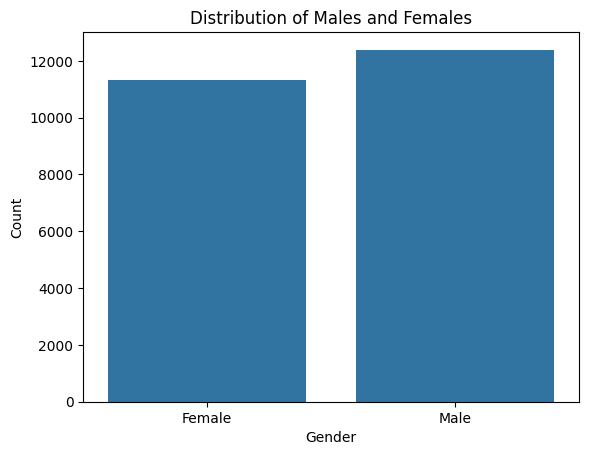

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

df['gender_label'] = df['gender'].map(gender_dict)

# Plot the count of males and females
sns.countplot(x='gender_label', data=df)
plt.title('Distribution of Males and Females')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


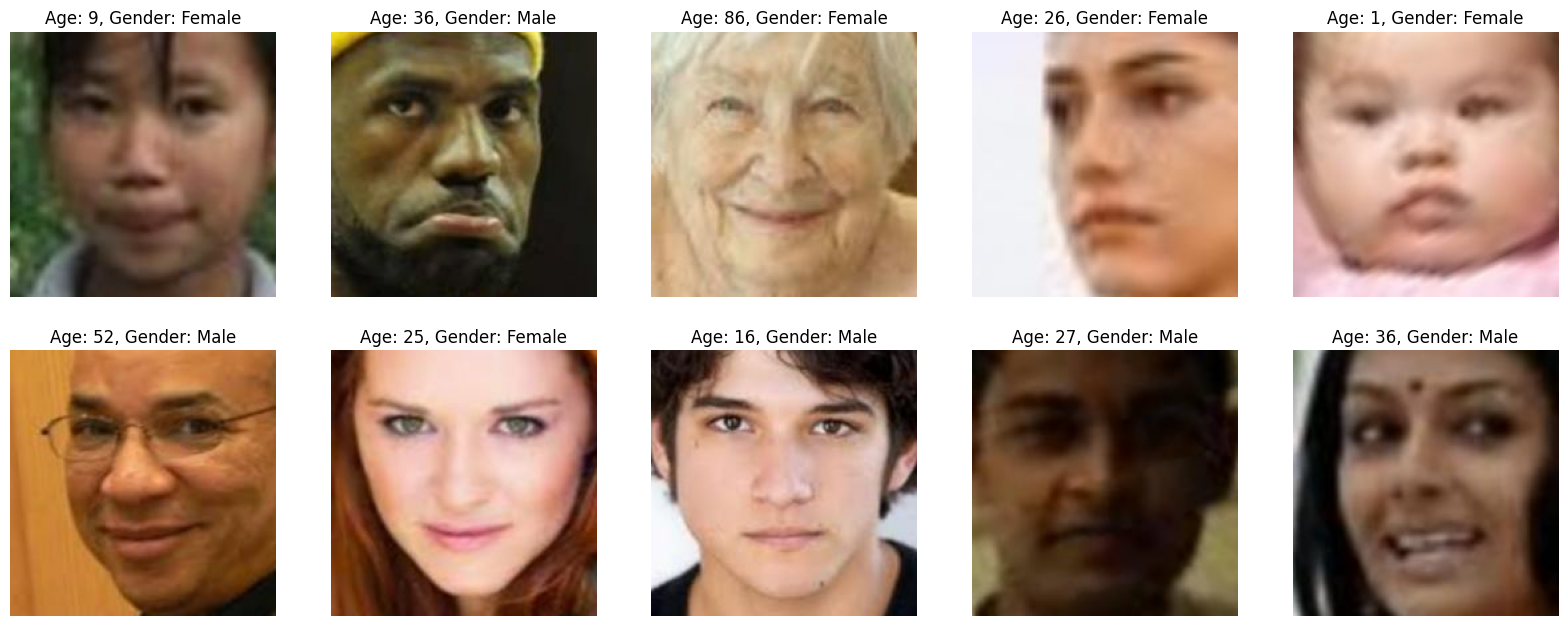

In [48]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender, *_ in files.itertuples():
    plt.subplot(5, 5, index+1) 
    img = load_img(file)
    plt.imshow(img)
    plt.title(f"Age: {age}, Gender: {gender_dict[gender]}")
    plt.axis('off')

plt.show()


In [49]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((48, 48), Image.LANCZOS)  
        img = np.array(img)
        features.append(img)
    return np.array(features)


X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [50]:
X.shape

(23708, 48, 48)

In [51]:
X = X/255.0

In [52]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [53]:
input_shape = (48, 48, 1)

In [54]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

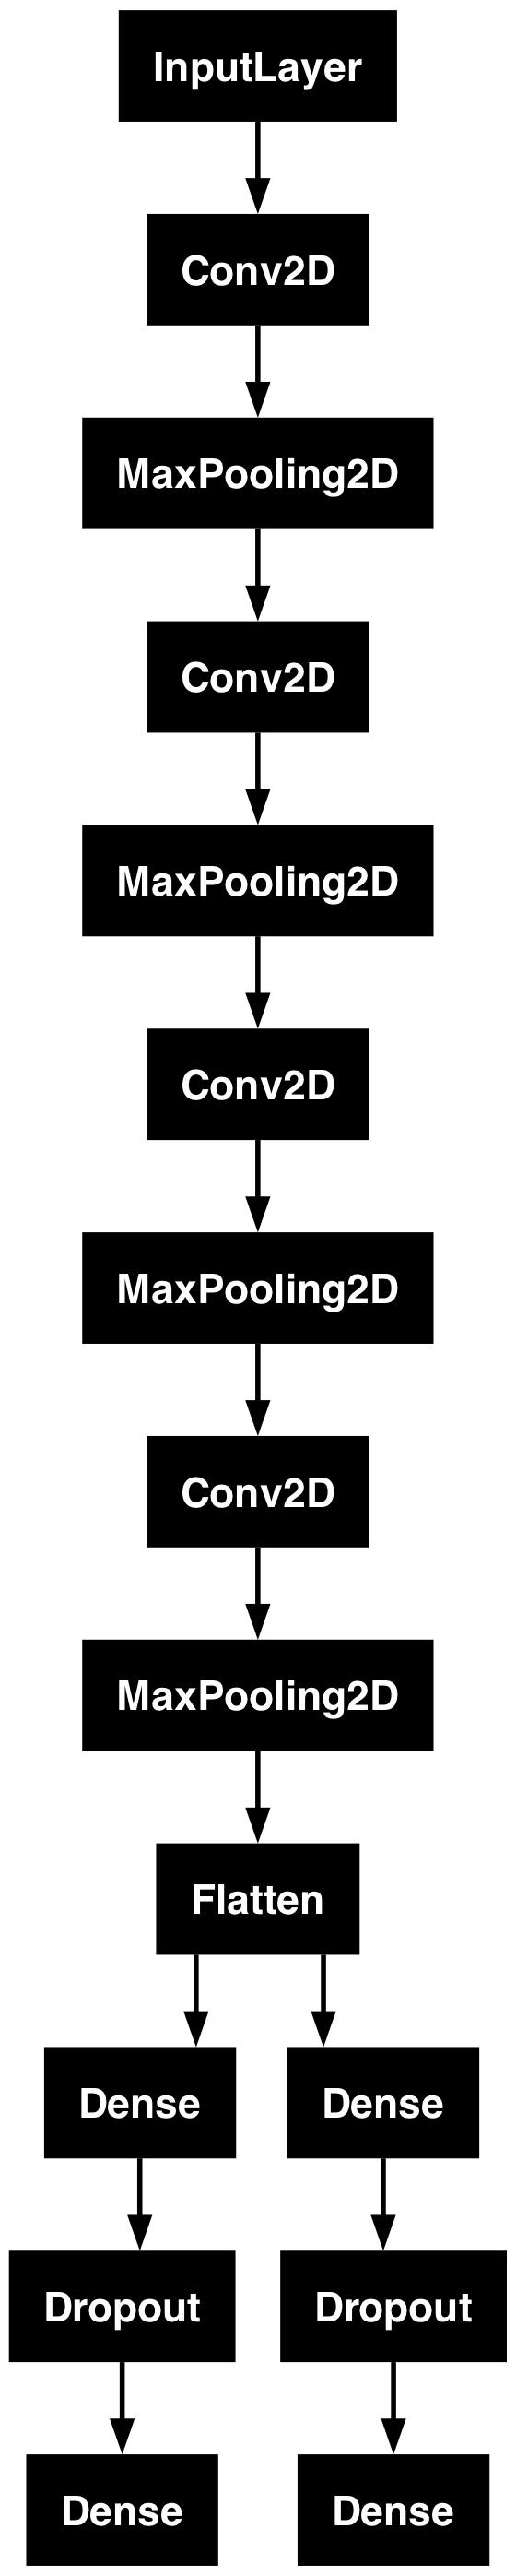

In [55]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [57]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - age_out_loss: 12.8173 - age_out_mae: 12.8173 - gender_out_accuracy: 0.6224 - gender_out_loss: 0.6455 - loss: 13.4627 - val_age_out_loss: 10.8766 - val_age_out_mae: 10.8847 - val_gender_out_accuracy: 0.7193 - val_gender_out_loss: 0.5507 - val_loss: 11.4355
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - age_out_loss: 10.6884 - age_out_mae: 10.6884 - gender_out_accuracy: 0.7221 - gender_out_loss: 0.5542 - loss: 11.2427 - val_age_out_loss: 10.0005 - val_age_out_mae: 10.0175 - val_gender_out_accuracy: 0.7240 - val_gender_out_loss: 0.5523 - val_loss: 10.5696
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - age_out_loss: 9.2519 - age_out_mae: 9.2519 - gender_out_accuracy: 0.7620 - gender_out_loss: 0.4915 - loss: 9.7434 - val_age_out_loss: 9.4270 - val_age_out_mae: 9.3959 - val_gender_out_accuracy: 0.7834 - val_gender_out_loss: 0.4419 - val_loss: 9.8379
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - age_out_loss: 8.41

In [63]:
model_json = model.to_json()
with open("agedetectorf.json",'w') as json_file:
    json_file.write(model_json)
model.save("agedetectorf.h5")

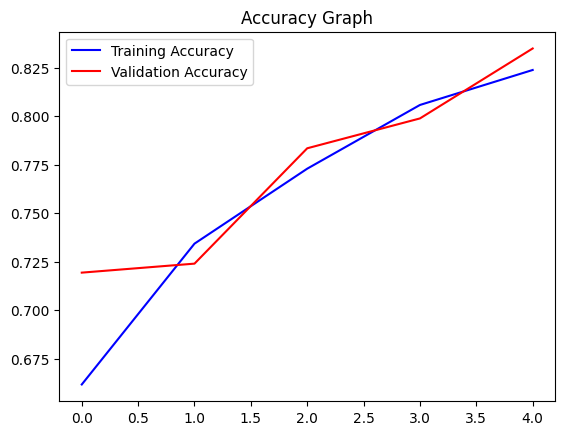

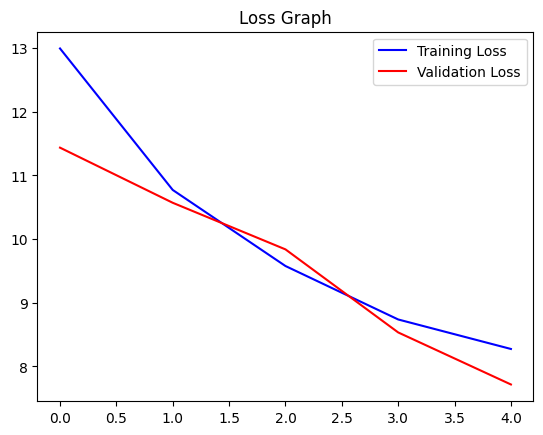

In [60]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

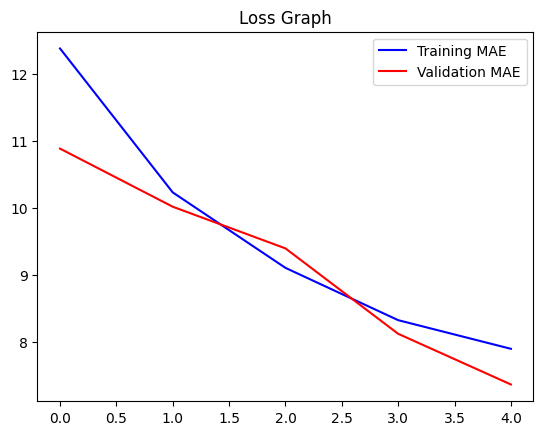

In [61]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Gender: Female Predicted Age: 38


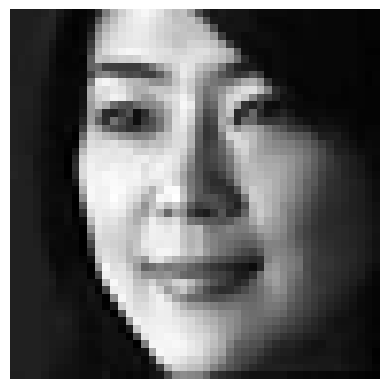

In [62]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 48, 48, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(48, 48), cmap='gray');